In [ ]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import platform
from matplotlib.ticker import FuncFormatter
import plotly.graph_objects as go
from matplotlib import rcParams
import csv

plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지


total22_df = pd.read_csv("전연령22_utf8.csv", low_memory=False)
senior22_df = pd.read_csv("노인승하차22_utf8.csv", low_memory=False)
total24_df = pd.read_csv("전연령24_utf8.csv", low_memory=False)
senior24_df = pd.read_csv("노인승하차24_utf8.csv", low_memory=False)
total23_df = pd.read_csv("전연령23_utf8.csv", low_memory=False)
senior23_df = pd.read_csv("노인승하차23_utf8.csv", low_memory=False)
#senior_care_df = pd.read_csv("senior_care_utf8.csv", low_memory=False) # 파일이 사라짐
sme_df = pd.read_csv("sme.csv", low_memory=False)
park_df = pd.read_csv("TB_PTP_PRK_M.csv", low_memory=False)
safety_df = pd.read_csv("안전사고_utf.csv", low_memory=False)
elderly_2020_2022 = pd.read_csv(
    "elderly2020_2022.csv",
    low_memory=False,
    quoting=csv.QUOTE_NONE,
    encoding="utf-8",
    on_bad_lines='skip'  # 문제 있는 라인은 건너뜀
)
elderly_2023_2025 = pd.read_csv(
    "elderly2023_2025.csv",
    low_memory=False,
    quoting=csv.QUOTE_NONE,
    encoding="utf-8",
    on_bad_lines='skip'
)


# 역별 승하차인원           => total22_df, total24_df
# 65세 노인 승하차인원      => senior22_df, senior24_df
# 노인요양시설(요양원)      => senior_care_df
# 종사자, 사업체 수         => sme_df
# 안전사고                  => safety_df

# ------------------
# 확인용
# print(total22_df.head())
# print(total22_df.columns)
# print(senior22_df.head())
# print(senior22_df.columns)
# print(safety_df.head())
# print(senior_care_df.head())
# print(senior_care_df.columns)
# print(sme_df.head())
# print(sme_df.columns)
# print(park_df.head())
# ------------------

Index(['"구분별"', '"동별"', '"항목"', '"단위"', '"2020. 01 월"', '"2020. 02 월"',
       '"2020. 03 월"', '"2020. 04 월"', '"2020. 05 월"', '"2020. 06 월"',
       '"2020. 07 월"', '"2020. 08 월"', '"2020. 09 월"', '"2020. 10 월"',
       '"2020. 11 월"', '"2020. 12 월"', '"2021. 01 월"', '"2021. 02 월"',
       '"2021. 03 월"', '"2021. 04 월"', '"2021. 05 월"', '"2021. 06 월"',
       '"2021. 07 월"', '"2021. 08 월"', '"2021. 09 월"', '"2021. 10 월"',
       '"2021. 11 월"', '"2021. 12 월"', '"2022. 01 월"', '"2022. 02 월"',
       '"2022. 03 월"', '"2022. 04 월"', '"2022. 05 월"', '"2022. 06 월"',
       '"2022. 07 월"', '"2022. 08 월"', '"2022. 09 월"', '"2022. 10 월"',
       '"2022. 11 월"', '"2022. 12 월"', 'Unnamed: 40'],
      dtype='object')


In [30]:

# ---------------------------
# 3. 시간대 컬럼 정의
# ---------------------------
time_cols = [
    '06시간대이전', '06-07시간대', '07-08시간대', '08-09시간대', '09-10시간대',
    '10-11시간대', '11-12시간대', '12-13시간대', '13-14시간대', '14-15시간대',
    '15-16시간대', '16-17시간대', '17-18시간대', '18-19시간대', '19-20시간대',
    '20-21시간대', '21-22시간대', '22-23시간대', '23-24시간대', '24시간대이후'
]

# ---------------------------
# 4. 일일총승객수 컬럼 생성 함수
# ---------------------------
def add_total_passengers(df):
    for col in time_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    df['일일총승객수'] = df[time_cols].sum(axis=1)
    return df

# 적용
senior22_df = add_total_passengers(senior22_df)
senior23_df = add_total_passengers(senior23_df)
senior24_df = add_total_passengers(senior24_df)
total22_df = add_total_passengers(total22_df)
total23_df = add_total_passengers(total23_df)
total24_df = add_total_passengers(total24_df)

# ---------------------------
# 5. 연도별 합계 계산
# ---------------------------
senior_totals = [
    senior22_df['일일총승객수'].sum(),
    senior23_df['일일총승객수'].sum(),
    senior24_df['일일총승객수'].sum()
]

total_totals = [
    total22_df['일일총승객수'].sum(),
    total23_df['일일총승객수'].sum(),
    total24_df['일일총승객수'].sum()
]

years = ['2022년', '2023년', '2024년']

# ---------------------------
# 6. 노인 비율과 증가율 계산
# ---------------------------
# 전연령 대비 노인 비율 (%)
senior_ratio = [s/t*100 for s, t in zip(senior_totals, total_totals)]

# 노인 증가율 (전년도 대비 %)
senior_increase_rate = [0] + [(senior_totals[i] - senior_totals[i-1])/senior_totals[i-1]*100 for i in range(1, len(senior_totals))]

# 전연령 증가율 (전년도 대비 %)
total_increase_rate = [0] + [(total_totals[i] - total_totals[i-1])/total_totals[i-1]*100 for i in range(1, len(total_totals))]

# ---------------------------
# 7. 시각화 (Plotly)
# ---------------------------
fig = go.Figure()

# 노인 승하차 합계 선 그래프
fig.add_trace(go.Scatter(
    x=years, y=senior_totals,
    mode='lines+markers',
    name='노인 승하차',
    line=dict(color='crimson', width=3),
    marker=dict(size=10)
))

# 전연령 승하차 합계 선 그래프
fig.add_trace(go.Scatter(
    x=years, y=total_totals,
    mode='lines+markers',
    name='전연령 승하차',
    line=dict(color='royalblue', width=3, dash='dot'),
    marker=dict(size=10)
))

# 증가율과 비율 주석 추가
for i, year in enumerate(years):
    # 노인 증가율 + 비율
    fig.add_annotation(
        x=year, y=senior_totals[i],
        text=f"증가율: {senior_increase_rate[i]:.1f}%<br>비율: {senior_ratio[i]:.1f}%",
        showarrow=True,
        arrowhead=2,
        ax=0,
        ay=-40,
        font=dict(color='black', size=12)
    )
    # 전연령 증가율
    fig.add_annotation(
        x=year, y=total_totals[i],
        text=f"전연령 증가율: {total_increase_rate[i]:.1f}%",
        showarrow=True,
        arrowhead=2,
        ax=0,
        ay=40,
        font=dict(color='royalblue', size=12)
    )

# 레이아웃 설정
fig.update_layout(
    title="2022~2024년 65세 이상 vs 전연령 승하차 비교",
    xaxis_title="연도",
    yaxis_title="승하차 총량(명)",
    template="plotly_white"
)

fig.show()


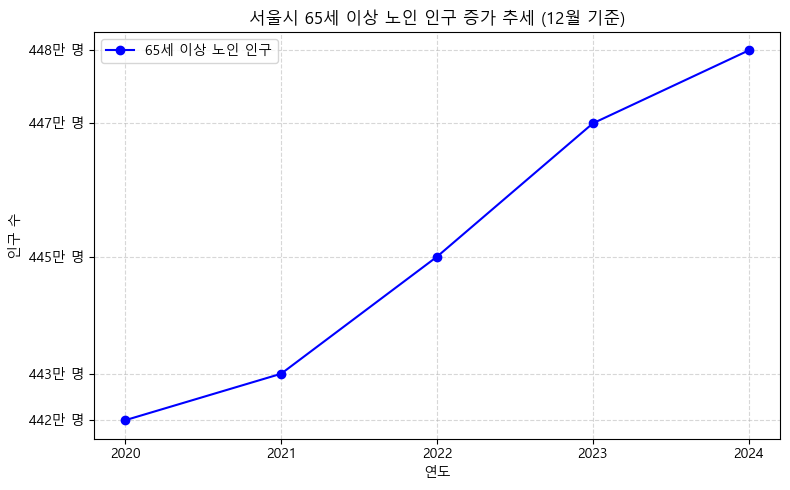

In [55]:

# -------------------------------
# 컬럼명과 문자열 공백 제거
# -------------------------------
for df in [elderly_2020_2022, elderly_2023_2025]:
    df.columns = df.columns.str.replace('"', '').str.strip()
    df['구분별'] = df['구분별'].astype(str).str.replace('"','').str.strip()
    df['동별'] = df['동별'].astype(str).str.replace('"','').str.strip()

# -------------------------------
# 합계 행 필터링
# -------------------------------
sum_2020_2022 = elderly_2020_2022[(elderly_2020_2022['구분별']=='세대') & 
                                  (elderly_2020_2022['동별']=='합계')]
sum_2023_2025 = elderly_2023_2025[(elderly_2023_2025['구분별']=='세대') & 
                                  (elderly_2023_2025['동별']=='합계')]

# -------------------------------
# 12월 데이터 컬럼
# -------------------------------
dec_columns_2020_2022 = ['2020. 12 월', '2021. 12 월', '2022. 12 월']
dec_columns_2023_2025 = ['2023. 12 월', '2024. 12 월']

# -------------------------------
# 문자열 -> 숫자 변환 (쉼표, 공백 제거)
# -------------------------------
def clean_to_int(series):
    return series.replace(r'[",\s]', '', regex=True).astype(int)

elderly_dec_2020_2022 = clean_to_int(sum_2020_2022[dec_columns_2020_2022].iloc[0])
elderly_dec_2023_2025 = clean_to_int(sum_2023_2025[dec_columns_2023_2025].iloc[0])

# -------------------------------
# 연도별 시리즈 합치기
# -------------------------------
elderly_dec_series = pd.concat([elderly_dec_2020_2022, elderly_dec_2023_2025])
elderly_dec_series.index = [2020, 2021, 2022, 2023, 2024]

# -------------------------------
# 만 명 단위로 변환
# -------------------------------
values_in_10k = elderly_dec_series.values / 10000  # 만 명 단위

# -------------------------------
# 그래프 그리기
# -------------------------------
plt.figure(figsize=(8,5))
plt.plot(elderly_dec_series.index, values_in_10k, marker='o', linestyle='-', color='blue', label='65세 이상 노인 인구')

# y축 숫자 옆에 '만 명' 단위 표시
formatter = FuncFormatter(lambda x, pos: f'{x:.0f}만 명')
plt.gca().yaxis.set_major_formatter(formatter)

# y축 눈금을 **데이터 값만 표시** (자동 증가 막음)
plt.yticks(values_in_10k)

plt.title('서울시 65세 이상 노인 인구 증가 추세 (12월 기준)')
plt.xlabel('연도')
plt.ylabel('인구 수')
plt.xticks(elderly_dec_series.index)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


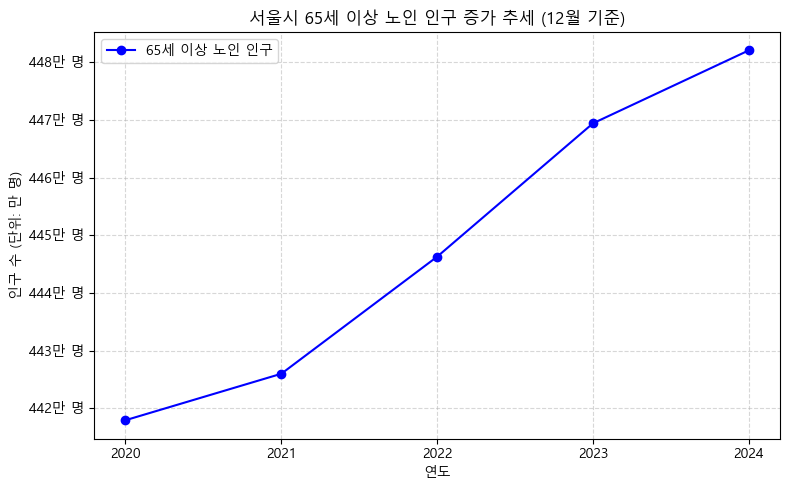

In [54]:

# -------------------------------
# 컬럼명과 문자열 공백 제거
# -------------------------------
for df in [elderly_2020_2022, elderly_2023_2025]:
    df.columns = df.columns.str.replace('"', '').str.strip()
    df['구분별'] = df['구분별'].astype(str).str.replace('"','').str.strip()
    df['동별'] = df['동별'].astype(str).str.replace('"','').str.strip()

# -------------------------------
# 합계 행 필터링
# -------------------------------
sum_2020_2022 = elderly_2020_2022[(elderly_2020_2022['구분별']=='세대') & 
                                  (elderly_2020_2022['동별']=='합계')]
sum_2023_2025 = elderly_2023_2025[(elderly_2023_2025['구분별']=='세대') & 
                                  (elderly_2023_2025['동별']=='합계')]

# -------------------------------
# 12월 데이터 컬럼
# -------------------------------
dec_columns_2020_2022 = ['2020. 12 월', '2021. 12 월', '2022. 12 월']
dec_columns_2023_2025 = ['2023. 12 월', '2024. 12 월']

# -------------------------------
# 문자열 -> 숫자 변환
# -------------------------------
def clean_to_int(series):
    return series.replace(r'[",\s]', '', regex=True).astype(int)

elderly_dec_2020_2022 = clean_to_int(sum_2020_2022[dec_columns_2020_2022].iloc[0])
elderly_dec_2023_2025 = clean_to_int(sum_2023_2025[dec_columns_2023_2025].iloc[0])

# -------------------------------
# 연도별 시리즈 합치기
# -------------------------------
elderly_dec_series = pd.concat([elderly_dec_2020_2022, elderly_dec_2023_2025])
elderly_dec_series.index = [2020, 2021, 2022, 2023, 2024]

# -------------------------------
# [수정됨] 만 단위로 변환 (기존 1e8 -> 10000)
# -------------------------------
values_in_10k = elderly_dec_series.values / 10000

# -------------------------------
# 그래프 그리기
# -------------------------------
plt.figure(figsize=(8,5))
plt.plot(elderly_dec_series.index, values_in_10k, marker='o', linestyle='-', color='blue', label='65세 이상 노인 인구')

# [수정됨] y축 숫자 옆에 "만 명" 붙이기, 소수점 제거하고 쉼표 추가
formatter = FuncFormatter(lambda x, pos: f'{x:,.0f}만 명')
plt.gca().yaxis.set_major_formatter(formatter)

plt.title('서울시 65세 이상 노인 인구 증가 추세 (12월 기준)')
plt.xlabel('연도')
plt.ylabel('인구 수 (단위: 만 명)') # y축 라벨에도 단위 표시 추가
plt.xticks(elderly_dec_series.index)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()